---
title: Random Forests
---

Here we will follow a similar process as seen in the Decision Trees tab, but instead creating a Random Forest model to see if that results in better performance. The explanation of this process will be less detailed here as the inital setup is very similar to the process seen in the decision trees tab, for a more in depth explanation of the setup that tab.

In [2]:
#| code-fold: true
#| code-summary: "Imports"

import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Import Data

In [3]:
#| code-fold: true
#| code-summary: "Imports Data and Train/Test Split"

df = pd.read_csv("data/df.csv").drop(["coach", "posteam_score", "defteam_score"], axis=1)
pd.set_option('display.float_format', '{:.2f}'.format)

X = df.loc[:,["game_half", "half_seconds_remaining", "ydstogo", "yardline_100", "score_diff"]]
Y = df["go"]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=621)

# Check size of train and test splits
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (22315, 5)
y_train shape: (22315,)
x_test shape: (5579, 5)
y_test shape: (5579,)


# Training the Model

In [4]:
clf = RandomForestClassifier(n_estimators=100, random_state=621)
model = clf.fit(x_train.values, y_train)

For now we will have a `n_estimators` parameter of 100, though that hyperparameter will be tuned later. 

# Check the Model

------TEST------
ACCURACY:  0.912
NEGATIVE RECALL (Y=0):  0.961
NEGATIVE PRECISION (Y=0):  0.935
POSITIVE RECALL (Y=1):  0.659
POSITIVE PRECISION (Y=1):  0.77
[[4483  180]
 [ 312  604]]


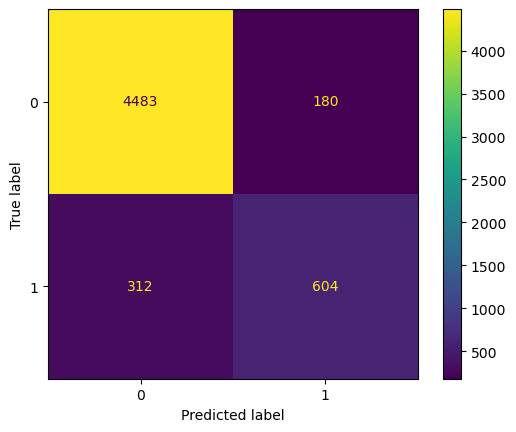

In [5]:
#| code-fold: true
#| code-summary: "Generate Confusion Matrices"

yp_train = model.predict(x_train.values)
yp_test = model.predict(x_test.values)

def confusion_plot(y_data, y_pred):
    cm = confusion_matrix(y_data, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    print("ACCURACY: ", round(accuracy_score(y_data, y_pred), 3))
    print("NEGATIVE RECALL (Y=0): ", round(recall_score(y_data, y_pred, pos_label=0), 3))
    print("NEGATIVE PRECISION (Y=0): ", round(precision_score(y_data, y_pred, pos_label=0), 3))
    print("POSITIVE RECALL (Y=1): ", round(recall_score(y_data, y_pred, pos_label=1), 3))
    print("POSITIVE PRECISION (Y=1): ", round(precision_score(y_data, y_pred, pos_label=1), 3))
    print(cm)
    disp.plot()
    plt.show()
    
# print("------TRAINING------")
# confusion_plot(y_train,yp_train)

print("------TEST------")
confusion_plot(y_test,yp_test)

Negative recall and precision are very good, meaning our model is good at predicting when coaches will not go for it, which makes sense. Positive recall and precision, on the other hand, are not nearly as good. It is much harder to predict when coaches will go for it than when they will not go for it. This model is slightly better than our decision tree so far, though we have yet to tune the model.

# Hyperparameter Tuning

In [12]:
#| code-fold: true
#| code-summary: "`n_estimators` Tuning"

test_results=[]
train_results=[]

for n_estimators in range(100, 1000, 100):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=621)
    model = clf.fit(x_train, y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([n_estimators,
    accuracy_score(y_test, yp_test),
    recall_score(y_test, yp_test,pos_label=0),
    recall_score(y_test, yp_test,pos_label=1)])
    
    train_results.append([n_estimators,
    accuracy_score(y_train, yp_train),
    recall_score(y_train, yp_train,pos_label=0),
    recall_score(y_train, yp_train,pos_label=1)])

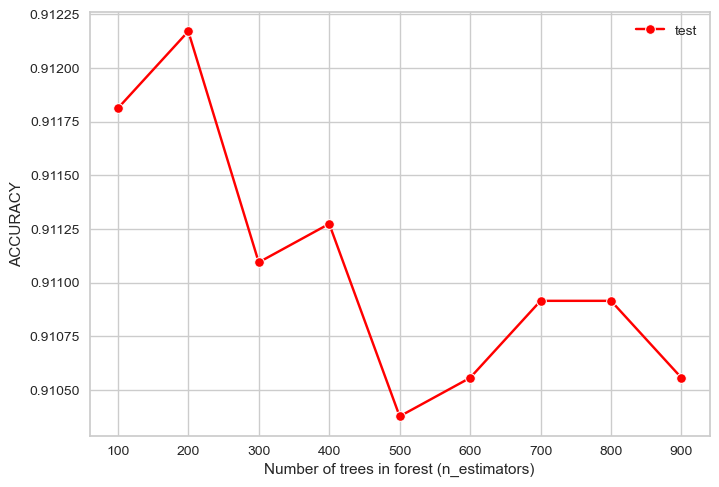

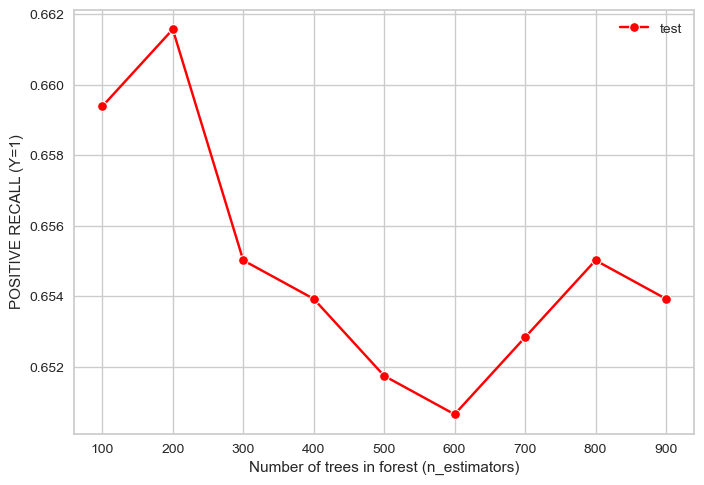

In [18]:
#| code-fold: true
#| code-summary: "`n_estimators` Plots"

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,1],
                color="red",
                marker="o",
                label="test")
ax.set(xlabel="Number of trees in forest (n_estimators)", ylabel="ACCURACY")
plt.legend()
plt.show()

plt.cla()
ax = sns.lineplot(x=np.asarray(test_results)[:,0],
                y=np.asarray(test_results)[:,3],
                color="red",
                marker="o",
                label="test")
ax.set(xlabel="Number of trees in forest (n_estimators)", ylabel="POSITIVE RECALL (Y=1)")
plt.legend()
plt.show()

200 appears to be the optimal `n_estimators` parameter, we will fit a model with that value. Note also that the accuracy at that level of estimators is over 91%, meaning we have an excellent model.

# Feature Importance

As it is difficult to visualize the trees in a random forest due to their compelxity, we can visualize the importance of each of the features, allowing us to compare this model to the previous decision tree model.

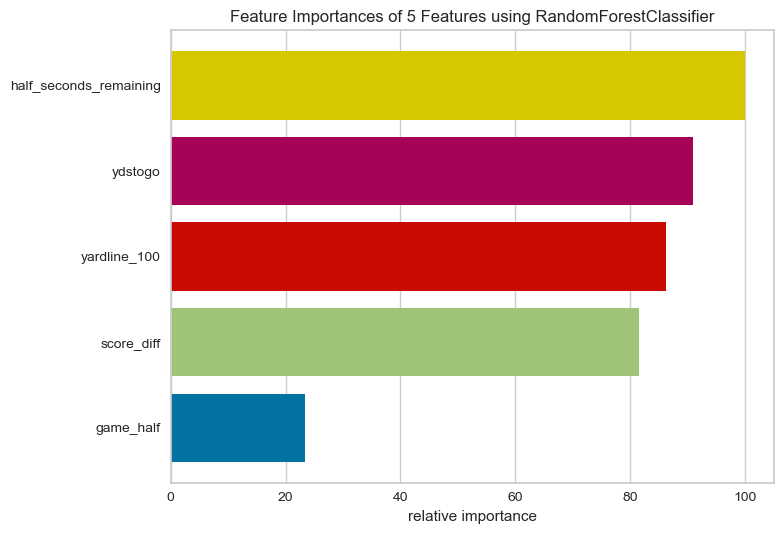

<Axes: title={'center': 'Feature Importances of 5 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [17]:
#| code-fold: true
#| code-summary: Feature Importance

from yellowbrick.model_selection import FeatureImportances

clf = RandomForestClassifier(n_estimators=200, random_state=621)
model = clf.fit(x_train.values, y_train)

# Visualize feature importances
viz = FeatureImportances(model)
viz.fit(x_train, y_train)
viz.show()


A difference we can see here is that all features are considered important, which makes sense due to the complexity of this model. `game_half` is clearly the least important features, with all others being of similar importance. Making this type of graph for each individual coach would give us important insights into their decision making processes, as we can see what game state characteristics they value more than others. This plot is, in a way, a baseline metric by which to compare all other coaches to. Since this model was fitted with data from every coach, it can be considered what the "average" NFL coach considered when making a 4th down decision. If the order of features is different for another coach, they approach 4th downs differently than the average coach, something that will be interesting to see.